In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu, threshold_sauvola
from skimage.morphology import opening, disk

In [2]:
image_root = "data/images"
mask_root  = "data/masks"

In [3]:
def dice_score(pred, gt):
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    if gt.sum() == 0:
        return None
    intersection = (pred & gt).sum()
    return (2 * intersection) / (pred.sum() + gt.sum() + 1e-6)


def jaccard_index(pred, gt):
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    if gt.sum() == 0:
        return None
    intersection = (pred & gt).sum()
    union = (pred | gt).sum()
    return intersection / (union + 1e-6)

In [12]:
dice_o, jac_o = [], []
dice_s, jac_s = [], []

used_images = 0
skipped_images = 0

In [13]:
for cls in sorted(os.listdir(image_root)):

    img_cls_path = os.path.join(image_root, cls)
    mask_cls_path = os.path.join(mask_root, cls)

    if not os.path.isdir(img_cls_path):
        continue

    for img_name in sorted(os.listdir(img_cls_path)):

        img_path = os.path.join(img_cls_path, img_name)
        mask_path = os.path.join(mask_cls_path, img_name)

        if not os.path.exists(mask_path):
            continue

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            continue

        # ensure mask and image have same size
        if mask.shape != image.shape:
            mask = cv2.resize(
                mask,
                (image.shape[1], image.shape[0]),
                interpolation=cv2.INTER_NEAREST
            )

        mask_bin = (mask > 0).astype(np.uint8)

        # skip images with no tumor
        if mask_bin.sum() == 0:
            skipped_images += 1
            continue

        used_images += 1

        # -------- OTSU (tumor darker) --------
        otsu_thresh = threshold_otsu(image)
        otsu_seg = (image < otsu_thresh).astype(np.uint8)

        # -------- SAUVOLA --------
        sauvola_thresh = threshold_sauvola(image, window_size=25, k=0.2)
        sauvola_seg = (image < sauvola_thresh).astype(np.uint8)

        # noise removal
        otsu_seg = opening(otsu_seg, disk(2))
        sauvola_seg = opening(sauvola_seg, disk(2))

        # metrics
        dice_o.append(dice_score(otsu_seg, mask_bin))
        jac_o.append(jaccard_index(otsu_seg, mask_bin))

        dice_s.append(dice_score(sauvola_seg, mask_bin))
        jac_s.append(jaccard_index(sauvola_seg, mask_bin))

In [14]:
dice_o = np.array([d for d in dice_o if d is not None])
jac_o  = np.array([j for j in jac_o if j is not None])
dice_s = np.array([d for d in dice_s if d is not None])
jac_s  = np.array([j for j in jac_s if j is not None])

print("Images used (tumor present):", used_images)
print("Images skipped (no tumor):", skipped_images)

print("\n========= FINAL RESULTS =========")
print("Otsu Dice Score      :", dice_o.mean())
print("Otsu Jaccard Score   :", jac_o.mean())
print("Sauvola Dice Score   :", dice_s.mean())
print("Sauvola Jaccard Score:", jac_s.mean())

Images used (tumor present): 1
Images skipped (no tumor): 0

========= FINAL RESULTS =========
Otsu Dice Score      : 0.0009689190889582929
Otsu Jaccard Score   : 0.0004846943592876586
Sauvola Dice Score   : 0.016003375476318873
Sauvola Jaccard Score: 0.008066231201457297


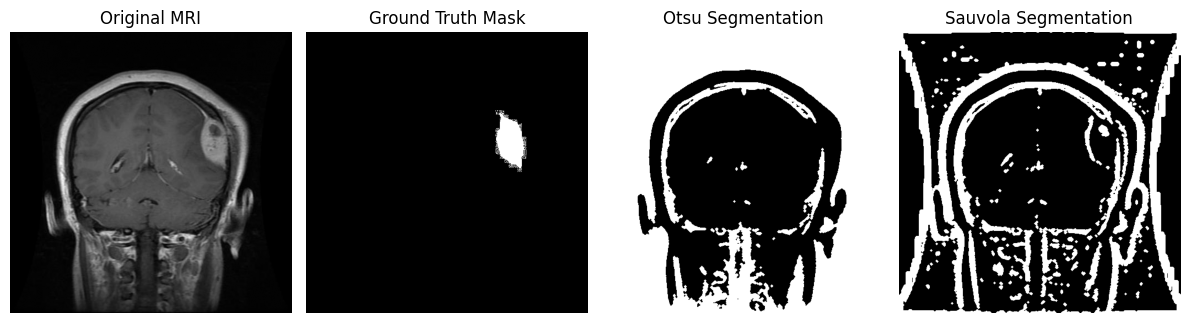

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title("Original MRI")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(mask_bin, cmap='gray', vmin=0, vmax=1)
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(otsu_seg, cmap='gray', vmin=0, vmax=1)
plt.title("Otsu Segmentation")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(sauvola_seg, cmap='gray', vmin=0, vmax=1)
plt.title("Sauvola Segmentation")
plt.axis('off')

plt.tight_layout()
plt.show()

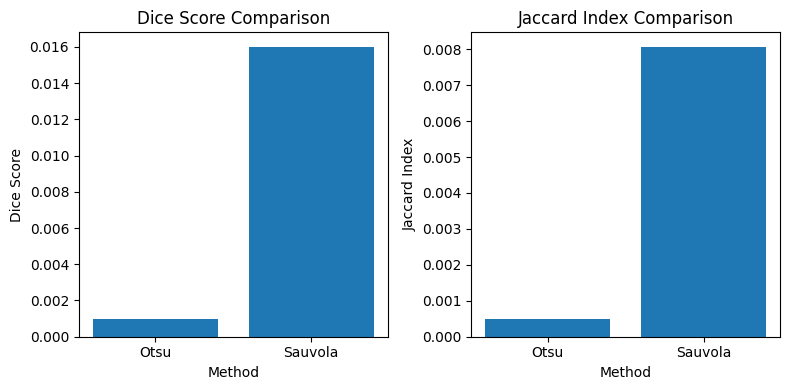

In [19]:
methods = ["Otsu", "Sauvola"]

dice_scores = [np.mean(dice_o), np.mean(dice_s)]
jaccard_scores = [np.mean(jac_o), np.mean(jac_s)]

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.bar(methods, dice_scores)
plt.title("Dice Score Comparison")
plt.xlabel("Method")
plt.ylabel("Dice Score")

plt.subplot(1, 2, 2)
plt.bar(methods, jaccard_scores)
plt.title("Jaccard Index Comparison")
plt.xlabel("Method")
plt.ylabel("Jaccard Index")

plt.tight_layout()
plt.show()